In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import json
import duckdb
import pathlib
import os, shutil
import matplotlib.pyplot as plt
import math
from pathlib import Path

In [1]:
DATA_SOURCE = "huggingface"  # or "csv"
HUGGINGFACE_DATASET = "Hacker0x01/disclosed_reports"  # can be replaced
CSV_PATH = "data/your_data.csv"

### Phase 1 - Ingestion (Bronze Layer)

**Goal**: Bring in raw HackerOne disclosed reports data from all splits (train, validation, test) into a single dataset.

**Steps**:

1. **Load & Merge:**
* Pull all dataset splits into Pandas and merge into one DataFrame.
* Why: Gives us a complete view for analysis instead of partial subsets.

2. **Schema Consistency:**
* Replace null dict fields (reporter, team, weakness, structured_scope) with {} to avoid schema breaks.
Serialize these as JSON strings for easy storage and parsing later.
* AI tie-in: Text fields are preserved exactly as in source → usable for NLP models later.

3. **Data Type Casting:**
* Convert all date fields (created_at, disclosed_at) to datetime.
* Why: Enables time-series analysis, SLA calculations, and model features like “report age”.

In [ ]:
train_ds = load_dataset('Hacker0x01/disclosed_reports', split = "train").to_pandas()
test_ds = load_dataset('Hacker0x01/disclosed_reports', split = 'test').to_pandas()
validate_ds = load_dataset('Hacker0x01/disclosed_reports', split = 'validation').to_pandas()

df = pd.concat([train_ds, test_ds, validate_ds], ignore_index = True)

# for any null dict fields, add {} to them instead of them being blank
for c in ['reporter', 'team', 'weakness', 'structured_scope']:
  df[c] = df[c].apply(lambda x : x if isinstance(x, dict) else {})

  df[c + "_json"] = df[c].apply(
      lambda d : json.dumps(
          {k : (v.tolist() if isinstance(v, np.ndarray) else v) for k,v in d.items()},
          sort_keys = True,
          ensure_ascii =  False
      )
  )

#convert date fields to datetime
df['created_at'] = pd.to_datetime(df.get("created_at"), errors = "coerce")
df['disclosed_at'] = pd.to_datetime(df.get("disclosed_at"), errors = "coerce")

bronze_cols = [ "id", "title", "created_at", "disclosed_at", "substate", "visibility", "has_bounty?", "vote_count",
               "original_report_id", "reporter_json", "team_json", "weakness_json", "structured_scope_json", "vulnerability_information" ]

bronze = df[[c for c in bronze_cols if c in df.columns]]
bronze.to_parquet("bronze_hackerone_reports.parquet", index = False)
bronze.to_csv("raw_data.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.93M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10094 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1262 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1262 [00:00<?, ? examples/s]

In [ ]:
# connect to DuckDB and register bronze layer (mirroring AWS S3/Snowflake's Staging Area in enterprise)
con = duckdb.connect("hackerone.duckdb")
con.execute("INSTALL parquet; LOAD parquet;")
con.execute("INSTALL json; LOAD json;")
con.execute("CREATE OR REPLACE VIEW bronze AS SELECT * FROM read_parquet('bronze_hackerone_reports.parquet');")

### Phase 2 – Transformation (Silver Layer)
**Goal**: Standardize and normalize data into relational structures.

**Steps**:

1. **Unnest JSON Fields:**
* Extract nested keys from JSON (team_handle, reporter_username, weakness_name, etc.).
* Why: Flat schema makes it easy for SQL queries, BI tools, and ML feature engineering.

2. **Data Cleaning & Standardization:**
* Lowercase categorical fields like substate, max_severity and asset_type.
* Remove extra whitespace or inconsistent casing in textual attributes(eg, weakness names)
* Why: Ensures consistent join keys and avoids grouping mismatches in analytics.

3. **Prepare for Surrogate Keys**:
* Keep the original JSON intact alongside flattened fields.
* These JSON blobs will be hashed in Phase 3 to produce stable, privacy-safe surrogate keys.


**How we do this in production:**
* Run transformations using dbt/Spark SQL/Snowflake for scalability and version control.
* Store Silver data in analytics-friendly formats (Parquet, Snowflake tables).
* Maintain automated data quality checks (e.g., dbt tests) to catch nulls, type mismatches, or key duplication before data is promoted to Gold.

In [ ]:
# create staging table with clean/standardized scalar columns
con.sql("""
    CREATE OR REPLACE TABLE stg_reports AS
    SELECT
    CAST(id as BIGINT) as report_id,
    title,
    LOWER(NULLIF(substate,'')) as substate, --normalised casing
    visibility,
    "has_bounty?" as has_bounty,
    CAST(vote_count AS INTEGER) as vote_count,
    CAST(created_at AS TIMESTAMP) as created_at,
    CAST(disclosed_at AS TIMESTAMP) as disclosed_at,
    CAST(original_report_id AS BIGINT) as original_report_id,
    reporter_json,
    weakness_json,
    team_json,
    structured_scope_json,
    vulnerability_information
    FROM bronze;
""")

#stage normalised tables ie, flatten JSON into typed columns
con.sql("""
    CREATE OR REPLACE TABLE stg_reporter AS
    SELECT DISTINCT
    reporter_json,
    json_extract_string(reporter_json, '$.username') as username,
    CAST(json_extract(reporter_json, '$.verified') AS BOOLEAN) as verified
    from bronze;
""")

con.sql("""
    CREATE OR REPLACE TABLE stg_team AS
    SELECT DISTINCT
    team_json,
    json_extract_string(team_json, '$.handle') as handle,
    CAST(json_extract(team_json, '$.id') AS BIGINT) as id,
    CAST(json_extract(team_json,'$.offers_bounties') AS BOOLEAN) AS offers_bounties
    from bronze;
""")

con.sql("""
    CREATE OR REPLACE TABLE stg_weakness AS
    SELECT DISTINCT
    weakness_json,
    json_extract_string(weakness_json,'$.name') AS weakness_name,
    CAST(json_extract(weakness_json, '$.id') AS BIGINT) as id,
    FROM bronze;
""")

con.sql("""
CREATE OR REPLACE TABLE stg_asset AS
SELECT DISTINCT
  structured_scope_json,
  json_extract_string(structured_scope_json,'$.asset_identifier') AS asset_identifier,
  json_extract_string(structured_scope_json,'$.asset_type')       AS asset_type,
  json_extract_string(structured_scope_json,'$.max_severity')     AS max_severity
FROM bronze;
""")

### Phase 3 – Star Schema (Gold Layer)

**Goal:** Build a Source of Truth model (star schema) with conformed dimensions and a single fact table.

**Steps**:
1. **Generate Surrogate Keys:**
* Apply hash(JSON) on each entity’s raw JSON to generate a stable, privacy-safe surrogate key (reporter_id, team_id, weakness_id, asset_id).
* Why: Maintains join consistency across all downstream systems while protecting sensitive identifiers (handles, usernames, etc.).

2. **Dimension Tables:**
* dim_reporter, dim_team, dim_weakness, dim_structured_scope — one row per unique entity, keyed by surrogate ID.
* Conformed (consistent) across all marts and use cases.

3. **Fact Table:**
* fact_report — one row per report, with:
* Natural key (report_id)
* Foreign keys to all four dimensions
* Core measures and attributes (has_bounty, vote_count, created_at, disclosed_at, substate)

**Why Star Schema:**
* Easy to query for BI tools (Looker/Tableau/Power BI).

* Clear separation of measures (facts) and descriptive attributes (dims).

* Facilitates incremental loads and SCD handling in production.

**How we do this in production:**

* Generate surrogate keys once in a controlled transformation job to guarantee stability.
* Enforce PK/FK relationships via schema constraints or dbt tests.
* Store Gold layer in a governed warehouse (Snowflake/BigQuery/Redshift) with strict access control, making it the single source of truth for all analytics & AI workloads.

**AI tie-in:** Clean, normalized entity attributes make it easier to build safe, PII-free ML feature sets downstream.

In [ ]:
con.sql("""
    CREATE OR REPLACE TABLE dim_reporter as
    SELECT DISTINCT
    hash(reporter_json) as reporter_id, -- surrogate_key
    username,
    verified
    FROM stg_reporter;
""")

con.sql("""
    CREATE OR REPLACE TABLE dim_team as
    SELECT DISTINCT
    hash(team_json) as team_id, -- surrogate_key
    id,
    handle,
    offers_bounties
    FROM stg_team;
""")

con.sql("""
    CREATE OR REPLACE TABLE dim_weakness as
    SELECT DISTINCT
    hash(weakness_json) as weakness_id, -- surrogate_key
    id,
    weakness_name
    FROM stg_weakness;
""")

con.sql("""
    CREATE OR REPLACE TABLE dim_structured_scope as
    SELECT DISTINCT
    hash(structured_scope_json) as asset_id, -- surrogate_key
    asset_identifier,
    asset_type,
    max_severity
    FROM stg_asset;
""")

In [ ]:
#fact table(one row per report, FK to dims)
con.sql("""
   CREATE OR REPLACE TABLE fact_report AS
   SELECT
    r.report_id,
    r.title,
    r.substate,
    r.visibility,
    r.has_bounty,
    r.vote_count,
    r.created_at,
    r.disclosed_at,
    r.original_report_id,
    hash(r.reporter_json) as reporter_id, --FK
    hash(r.team_json) as team_id, --FK
    hash(r.weakness_json) as weakness_id, --FK
    hash(r.structured_scope_json) as asset_id, --FK
    r.vulnerability_information
  FROM stg_reports r;
""")


### ER DIAGRAM

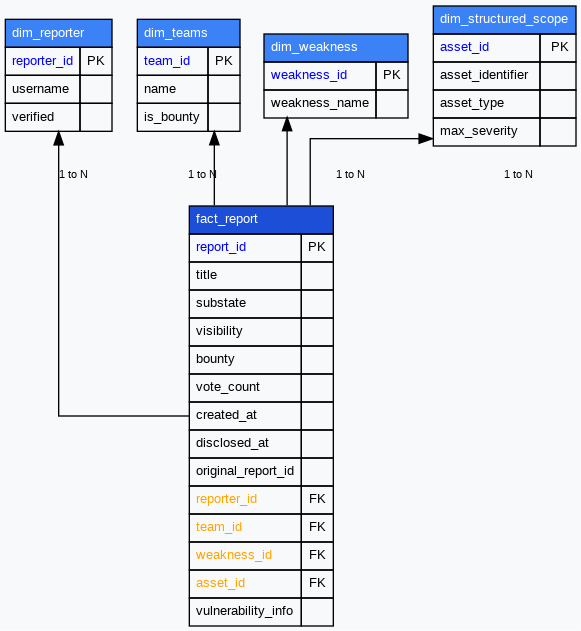



### Phase 4 – Data Quality Assurance (QA Layer)
**Goal**: Validate that Gold layer tables meet data integrity, completeness, and consistency standards before they are exposed to BI tools or AI models.

**Steps**:

1. Record Counts:
* Ensure no unexpected row loss or duplication between Bronze → Silver → Gold.
* Example: COUNT(DISTINCT report_id) in fact_report should match original dataset count (minus intentional filters).

2. **Key Integrity Checks:**
* All fact_report foreign keys (reporter_id, team_id, weakness_id, asset_id) must exist in their respective dimension tables.

3. **Null and Data Type Checks**:
* Confirm mandatory fields (e.g., created_at, substate) are non-null.
* Verify correct data types for dates, booleans, and integers.
* Referential Consistency:
* No orphaned dimension entries (dims without a matching fact) unless intentional for slowly changing dimensions.

**Why it matters:**
* Guarantees trust in the Source of Truth.
* Prevents BI dashboards or ML pipelines from producing misleading insights.

**How we do this in production:**
* Use dbt tests (unique, not_null, relationships) or Great Expectations to automate QA.
* Set up CI/CD checks so broken data never reaches production.
* Implement data quality alerts (Slack/Email) when thresholds fail.

In [ ]:
#quality checks - QA Proof: in prod this becomes dbt tests + alerts

#PK Present and unique
con.sql("SELECT COUNT(*) AS null_report_id FROM fact_report WHERE report_id IS NULL").show()
con.sql("""
  SELECT COUNT(*) AS duplicate_report_id
  FROM (SELECT report_id from fact_report GROUP BY 1 HAVING COUNT(*)>1)
""").show()

#temporal sanity
con.sql("""
SELECT COUNT(*) AS bad_time_order
FROM fact_report
WHERE created_at IS NOT NULL AND disclosed_at IS NOT NULL
  AND disclosed_at < created_at
""").show()

# Accepted values sample (substate distribution)
con.sql("""
SELECT substate, COUNT(*) AS reports
FROM fact_report
GROUP BY 1
ORDER BY reports DESC
""").show()

#FK Integrity
con.sql("""
SELECT COUNT(*) AS missing_asset_keys
FROM fact_report f
LEFT JOIN dim_structured_scope a on f.asset_id = a.asset_id
WHERE a.asset_id IS NULL;
""").show()

┌────────────────┐
│ null_report_id │
│     int64      │
├────────────────┤
│              0 │
└────────────────┘

┌─────────────────────┐
│ duplicate_report_id │
│        int64        │
├─────────────────────┤
│                   0 │
└─────────────────────┘

┌────────────────┐
│ bad_time_order │
│     int64      │
├────────────────┤
│              0 │
└────────────────┘

┌────────────────┬─────────┐
│    substate    │ reports │
│    varchar     │  int64  │
├────────────────┼─────────┤
│ resolved       │   11012 │
│ informative    │     995 │
│ not-applicable │     313 │
│ duplicate      │     271 │
│ spam           │      27 │
└────────────────┴─────────┘

┌────────────────────┐
│ missing_asset_keys │
│       int64        │
├────────────────────┤
│                  0 │
└────────────────────┘



### Phase 5 – Aggregation & Marts (Analytics Layer)
**Goal**: Create pre-aggregated, business-friendly datasets optimized for consumption by BI tools, APIs, and AI feature stores.


**Why Marts Matter:**
* Simplify queries for analysts and business users.
* Improve dashboard performance by avoiding heavy aggregations at runtime.
* Provide feature-ready datasets for AI/ML models.

**How we do this in production:**
* Create materialized views or incremental tables in the warehouse.
* Store in BI schema separate from operational schemas.
* Automate refreshes using orchestration tools (Airflow/Prefect) on a schedule or event trigger.
* For AI, register these marts in a feature store (Feast/Tecton) so ML teams can use them without re-engineering features.

In [ ]:
# quick data analysis

#counts + ranges
con.sql("""
  SELECT
   count(*) as rows_fact_report,
   min(created_at) as created_at_min,
   max(created_at) as created_at_max,
   min(disclosed_at) as disclosed_at_min,
   max(disclosed_at) as disclosed_at_max
   from fact_report
""").show()

# days to disclosure
con.sql("""
  with d as (
    select DATE_DIFF('day', created_at, disclosed_at) as dtd
    from fact_report
  )
  select avg(dtd) as mean_days_to_disclosure,
  from d
""").show()

# asset type distribution and timing
con.sql("""
    SELECT a.asset_type,
    count(*) as total_reports,
    count(distinct f.asset_id) as unique_assets
from fact_report f
left join dim_structured_scope a using (asset_id)
group by a.asset_type
order by total_reports desc
""").show()

con.sql("""
   SELECT
   a.asset_type,
   avg(DATE_DIFF('day', f.created_at, f.disclosed_at)) as mean_days,
   PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY DATE_DIFF('day', f.created_at, f.disclosed_at)) AS median_days
   from fact_report f
   left join dim_structured_scope a using (asset_id)
   group by a.asset_type
   order by mean_days desc
""").show()

#severity_proxy
con.sql("""
    SELECT
    a.max_severity,
    count(*) as reports
    from fact_report f
    left join dim_structured_scope a using (asset_id)
    group by a.max_severity
    order by reports desc
""").show()

┌──────────────────┬─────────────────────┬─────────────────────────┬─────────────────────┬─────────────────────────┐
│ rows_fact_report │   created_at_min    │     created_at_max      │  disclosed_at_min   │    disclosed_at_max     │
│      int64       │      timestamp      │        timestamp        │      timestamp      │        timestamp        │
├──────────────────┼─────────────────────┼─────────────────────────┼─────────────────────┼─────────────────────────┤
│            12618 │ 2011-07-27 19:59:52 │ 2024-05-07 15:11:55.288 │ 2013-11-07 00:00:00 │ 2024-05-15 23:05:13.217 │
└──────────────────┴─────────────────────┴─────────────────────────┴─────────────────────┴─────────────────────────┘

┌─────────────────────────┐
│ mean_days_to_disclosure │
│         double          │
├─────────────────────────┤
│       185.3530670470756 │
└─────────────────────────┘

┌──────────────────────────┬───────────────┬───────────────┐
│        asset_type        │ total_reports │ unique_assets │
│     

In [ ]:
#bounty rates overall and asset_type
con.sql("""
  SELECT
  ROUND(100 * AVG(CASE WHEN has_bounty then 1 else 0 end),2) as overall_bounty_rate_pct
  from fact_report
""").show()

con.sql("""
   SELECT
  a.asset_type,
  COUNT(*) AS total,
  SUM(CASE WHEN f.has_bounty THEN 1 ELSE 0 END) AS bounty_reports,
  ROUND(100 * AVG(CASE WHEN f.has_bounty THEN 1 ELSE 0 END), 2) AS bounty_rate_pct
FROM fact_report f
LEFT JOIN dim_structured_scope a USING (asset_id)
GROUP BY a.asset_type
ORDER BY bounty_rate_pct DESC;
""").show()

┌─────────────────────────┐
│ overall_bounty_rate_pct │
│         double          │
├─────────────────────────┤
│                   53.04 │
└─────────────────────────┘

┌──────────────────────────┬───────┬────────────────┬─────────────────┐
│        asset_type        │ total │ bounty_reports │ bounty_rate_pct │
│         varchar          │ int64 │     int128     │     double      │
├──────────────────────────┼───────┼────────────────┼─────────────────┤
│ CIDR                     │     2 │              2 │           100.0 │
│ OTHER_APK                │     2 │              2 │           100.0 │
│ HARDWARE                 │    45 │             44 │           97.78 │
│ APPLE_STORE_APP_ID       │    26 │             23 │           88.46 │
│ DOWNLOADABLE_EXECUTABLES │   134 │            112 │           83.58 │
│ GOOGLE_PLAY_APP_ID       │   117 │             92 │           78.63 │
│ OTHER                    │  1444 │           1086 │           75.21 │
│ URL                      │  2462 │   

In [ ]:
#text quality check - can be an LLM Utility
con.sql("""
  SELECT
  SUM(CASE WHEN LENGTH(COALESCE(vulnerability_information, '')) < 300 THEN 1 ELSE 0 END) AS thin_writeup_lt_300,
  SUM(CASE WHEN vulnerability_information IS NULL THEN 1 ELSE 0 END) AS missing_writeup,
  SUM(CASE WHEN LENGTH(COALESCE(title, '')) < 20 THEN 1 ELSE 0 END) AS thin_title_lt_20
FROM fact_report;

""").show()

┌─────────────────────┬─────────────────┬──────────────────┐
│ thin_writeup_lt_300 │ missing_writeup │ thin_title_lt_20 │
│       int128        │     int128      │      int128      │
├─────────────────────┼─────────────────┼──────────────────┤
│                4237 │               0 │              509 │
└─────────────────────┴─────────────────┴──────────────────┘



In [ ]:
## substate bucketing
con.sql("""
  WITH j AS (
  SELECT f.*,
  CASE
   WHEN LOWER(f.substate) LIKE '%duplicate%'   THEN 'duplicate'
   WHEN LOWER(f.substate) LIKE '%informative%' THEN 'informative'
   WHEN LOWER(f.substate) LIKE '%triaged%' OR LOWER(f.substate) LIKE '%resolved%'
   OR LOWER(f.substate) LIKE '%fixed%' OR LOWER(f.substate) LIKE '%closed%'
    THEN 'accepted_or_triaged'
            ELSE 'other'
          END AS substate_bucket
    FROM fact_report f
  )
  SELECT substate_bucket, COUNT(*) AS reports
  FROM j
  GROUP BY substate_bucket
  ORDER BY reports DESC;
""").show()

┌─────────────────────┬─────────┐
│   substate_bucket   │ reports │
│       varchar       │  int64  │
├─────────────────────┼─────────┤
│ accepted_or_triaged │   11012 │
│ informative         │     995 │
│ other               │     340 │
│ duplicate           │     271 │
└─────────────────────┴─────────┘



Quick facts based on above analysis:
1. Rows: 12,618
2. created_at: 2011-07-27 → 2024-05-07 (earliest is a bit older than we thought)
3. disclosed_at: 2013-11-07 → 2024-05-15
4. Median / Mean days_to_disclosure: 71.0 / 183.89
5. FK joins: 0 missing across asset/team/reporter/weakness
6. has_bounty: True/False, overall 53.04% bounty rate
7. Asset types present: e.g., URL, SOURCE_CODE, OTHER, WILDCARD, etc
8. Outcome mix (substate buckets): accepted_or_triaged 87.27%, informative 7.89%, duplicate 2.15%, other 2.69%
9. Volume by asset_type (top 5): URL 2462, OTHER 1444, SOURCE_CODE 1346, WILDCARD 986, DOWNLOADABLE_EXECUTABLES 134
10. Bounty rate by asset_type (major buckets): OTHER 75.21%, URL 61.21%, WILDCARD 55.58%, SOURCE_CODE 40.49%
(Some very high rates like HARDWARE ~97.78% have small counts)
11. Text quality signals: thin writeups (<300 chars) 33.58%; missing writeup 24.85% → supports AI summarization/quality scoring and triage assistance.


#### Business Marts creation

In [ ]:
## MART1: mart_asset_risk_by_type
## WHAT: Risk snapshot by asset_type with severity mix & relative recency
## WHY: Prioritize focus areas; feed asset-type specific AI models
## HOW: Based on volume/timing/bounty-rate diffs observed in profiling

con.sql("""
  CREATE OR REPLACE TABLE mart_asset_risk_by_type AS
WITH bounds AS (
  -- Anchor "recent" to dataset's own max disclosed_at
  SELECT MAX(disclosed_at) AS max_d FROM fact_report
),
joined AS (
  -- Attach asset_type + severity proxy from dim_structured_scope
  SELECT
    f.report_id, f.asset_id, f.created_at, f.disclosed_at, f.has_bounty,
    a.asset_type, a.max_severity
  FROM fact_report f
  LEFT JOIN dim_structured_scope a USING (asset_id)
)
SELECT
  j.asset_type,                                   -- grain
  COUNT(*) AS total_reports,
  COUNT(DISTINCT j.asset_id) AS unique_assets,

  -- relative recency: last 365 days from dataset max date
  SUM(CASE WHEN j.disclosed_at >= b.max_d - INTERVAL 365 DAY THEN 1 ELSE 0 END)
    AS reports_last_365d_rel,

  -- severity buckets (proxy from dim_asset.max_severity)
  SUM(CASE WHEN j.max_severity = 'critical' THEN 1 ELSE 0 END) AS critical_cnt,
  SUM(CASE WHEN j.max_severity = 'high'     THEN 1 ELSE 0 END) AS high_cnt,
  SUM(CASE WHEN j.max_severity = 'medium'   THEN 1 ELSE 0 END) AS medium_cnt,
  SUM(CASE WHEN j.max_severity = 'low'      THEN 1 ELSE 0 END) AS low_cnt,

  -- worst observed severity (priority order)
  CASE
    WHEN SUM(CASE WHEN j.max_severity='critical' THEN 1 ELSE 0 END) > 0 THEN 'critical'
    WHEN SUM(CASE WHEN j.max_severity='high'     THEN 1 ELSE 0 END) > 0 THEN 'high'
    WHEN SUM(CASE WHEN j.max_severity='medium'   THEN 1 ELSE 0 END) > 0 THEN 'medium'
    WHEN SUM(CASE WHEN j.max_severity='low'      THEN 1 ELSE 0 END) > 0 THEN 'low'
    ELSE 'none'
  END AS worst_observed_severity,

  -- simple weighted risk score for ranking
  SUM(CASE j.max_severity
        WHEN 'critical' THEN 10
        WHEN 'high'     THEN 6
        WHEN 'medium'   THEN 3
        WHEN 'low'      THEN 1
        ELSE 0 END) AS risk_score
FROM joined j
CROSS JOIN bounds b
GROUP BY j.asset_type
ORDER BY risk_score DESC, total_reports DESC;
""")
con.sql('SELECT * FROM mart_asset_risk_by_type ORDER BY risk_score DESC LIMIT 15;').show()

┌──────────────────────────┬───────────────┬───────────────┬───────────────────────┬──────────────┬──────────┬────────────┬─────────┬─────────────────────────┬────────────┐
│        asset_type        │ total_reports │ unique_assets │ reports_last_365d_rel │ critical_cnt │ high_cnt │ medium_cnt │ low_cnt │ worst_observed_severity │ risk_score │
│         varchar          │     int64     │     int64     │        int128         │    int128    │  int128  │   int128   │ int128  │         varchar         │   int128   │
├──────────────────────────┼───────────────┼───────────────┼───────────────────────┼──────────────┼──────────┼────────────┼─────────┼─────────────────────────┼────────────┤
│ URL                      │          2462 │           497 │                   208 │         2151 │       39 │        106 │      18 │ critical                │      22080 │
│ SOURCE_CODE              │          1346 │           284 │                   224 │         1305 │        1 │          5 │       0 │ c

In [ ]:
# mart_team_sla_and_outcomes
# What: Team/program health — throughput, speed, outcomes, bounty mix
# Why: SLA benchmarking, backlog prediction, staffing; AI: SLA-breach risk
# How decided: Median disclosure ~71d; accepted/triaged ~87%; bounty ~53% overall

con.sql("""
   CREATE OR REPLACE TABLE mart_team_sla_and_outcomes AS
WITH base AS (
  -- Minimal fields from fact_report
  SELECT report_id, team_id, created_at, disclosed_at, substate, has_bounty
  FROM fact_report
),
timed AS (
  -- Add cycle time in days
  SELECT
    b.*,
    date_diff('day', b.created_at, b.disclosed_at) AS days_to_disclosure
  FROM base b
),
bucketed AS (
  -- Normalize substate into stable buckets for KPIs
  SELECT
    t.*,
    CASE
      WHEN lower(substate) LIKE '%duplicate%'                      THEN 'duplicate'
      WHEN lower(substate) LIKE '%informative%'                    THEN 'informative'
      WHEN lower(substate) LIKE '%triaged%' OR lower(substate) LIKE '%resolved%'
        OR lower(substate) LIKE '%fixed%' OR lower(substate) LIKE '%closed%' THEN 'accepted_or_triaged'
      ELSE 'other'
    END AS substate_bucket
  FROM timed t
)
SELECT
  tm.team_id,                                         -- team PK
  tm.id                     AS team_external_id,      -- extra id from dim_team
  COALESCE(tm.handle, CAST(tm.team_id AS VARCHAR)) AS team_handle,
  tm.offers_bounties,                                 -- program setting

  -- Volume
  COUNT(b.report_id) AS reports_total,

  -- Speed (DuckDB quantile_cont ignores NULLs)
  AVG(b.days_to_disclosure)                 AS avg_days_to_disclosure,
  quantile_cont(b.days_to_disclosure, 0.5)  AS p50_days_to_disclosure,
  quantile_cont(b.days_to_disclosure, 0.9)  AS p90_days_to_disclosure,

  -- Outcomes (no FILTER; use SUM(CASE))
  SUM(CASE WHEN b.substate_bucket = 'duplicate'           THEN 1 ELSE 0 END) AS duplicate_cnt,
  SUM(CASE WHEN b.substate_bucket = 'informative'         THEN 1 ELSE 0 END) AS informative_cnt,
  SUM(CASE WHEN b.substate_bucket = 'accepted_or_triaged' THEN 1 ELSE 0 END) AS accepted_or_triaged_cnt,

  -- Bounty mix (boolean field)
  SUM(CASE WHEN b.has_bounty THEN 1 ELSE 0 END)                                     AS bounty_reports,
  100.0 * AVG(CASE WHEN b.has_bounty THEN 1.0 ELSE 0.0 END)                         AS bounty_rate_pct
FROM bucketed b
LEFT JOIN dim_team tm USING (team_id)
GROUP BY 1,2,3,4
ORDER BY reports_total DESC;
""")

con.sql('SELECT * FROM mart_team_sla_and_outcomes ORDER BY reports_total DESC LIMIT 15;').show()

┌──────────────────────┬──────────────────┬─────────────────────┬─────────────────┬───────────────┬────────────────────────┬────────────────────────┬────────────────────────┬───────────────┬─────────────────┬─────────────────────────┬────────────────┬────────────────────┐
│       team_id        │ team_external_id │     team_handle     │ offers_bounties │ reports_total │ avg_days_to_disclosure │ p50_days_to_disclosure │ p90_days_to_disclosure │ duplicate_cnt │ informative_cnt │ accepted_or_triaged_cnt │ bounty_reports │  bounty_rate_pct   │
│        uint64        │      int64       │       varchar       │     boolean     │     int64     │         double         │         double         │         double         │    int128     │     int128      │         int128          │     int128     │       double       │
├──────────────────────┼──────────────────┼─────────────────────┼─────────────────┼───────────────┼────────────────────────┼────────────────────────┼────────────────────────┼───────

In [ ]:
# mart_reporter_quality
# What: Researcher productivity + quality markers (duplicates/informative/accepted + bounty hit-rate)
# Why: Reputation scoring, invite-only programs, triage priority, incentive design
# How: Clear variance by reporter in outcomes and bounty hit-rate; enough volume for stable segmentation

con.sql("""
    -- MART: mart_reporter_quality (DuckDB)
-- WHAT: Researcher quality & productivity snapshot
-- WHY: Reputation, invites, triage priority, incentives
-- HOW: Bucket substates; aggregate outcomes+bounty by reporter

CREATE OR REPLACE TABLE mart_reporter_quality AS
WITH bucketed AS (
  -- Normalize messy substates into stable buckets for KPIs
  SELECT
    f.report_id,
    f.reporter_id,
    f.substate,
    f.has_bounty,
    CASE
      WHEN lower(f.substate) LIKE '%duplicate%'   THEN 'duplicate'
      WHEN lower(f.substate) LIKE '%informative%' THEN 'informative'
      WHEN lower(f.substate) LIKE '%triaged%' OR lower(f.substate) LIKE '%resolved%'
        OR lower(f.substate) LIKE '%fixed%' OR lower(f.substate) LIKE '%closed%' THEN 'accepted_or_triaged'
      ELSE 'other'
    END AS substate_bucket
  FROM fact_report f
  )
  SELECT
    r.reporter_id,
    r.username,
    r.verified,

    -- Volume
    COUNT(b.report_id) AS reports_total,

    -- Outcome mix (no FILTER)
    SUM(CASE WHEN b.substate_bucket = 'duplicate'           THEN 1 ELSE 0 END) AS duplicate_cnt,
    SUM(CASE WHEN b.substate_bucket = 'informative'         THEN 1 ELSE 0 END) AS informative_cnt,
    SUM(CASE WHEN b.substate_bucket = 'accepted_or_triaged' THEN 1 ELSE 0 END) AS accepted_or_triaged_cnt,

    -- Bounty hit-rate (boolean field)
    SUM(CASE WHEN b.has_bounty THEN 1 ELSE 0 END)                       AS bounty_reports,
    100.0 * AVG(CASE WHEN b.has_bounty THEN 1.0 ELSE 0.0 END)           AS bounty_rate_pct
  FROM bucketed b
  LEFT JOIN dim_reporter r USING (reporter_id)
  GROUP BY 1,2,3
  -- Optional guard: HAVING COUNT(*) >= 5
  ORDER BY reports_total DESC;
""")
con.sql('SELECT * FROM mart_reporter_quality ORDER BY reports_total DESC LIMIT 15;').show()

┌──────────────────────┬────────────┬──────────┬───────────────┬───────────────┬─────────────────┬─────────────────────────┬────────────────┬────────────────────┐
│     reporter_id      │  username  │ verified │ reports_total │ duplicate_cnt │ informative_cnt │ accepted_or_triaged_cnt │ bounty_reports │  bounty_rate_pct   │
│        uint64        │  varchar   │ boolean  │     int64     │    int128     │     int128      │         int128          │     int128     │       double       │
├──────────────────────┼────────────┼──────────┼───────────────┼───────────────┼─────────────────┼─────────────────────────┼────────────────┼────────────────────┤
│ 12282786184771148023 │ bobrov     │ false    │           108 │             2 │               0 │                     105 │             63 │ 58.333333333333336 │
│ 11003172225919188837 │ geeknik    │ true     │            77 │             1 │              10 │                      66 │             38 │  49.35064935064935 │
│ 14105426263484495859

In [ ]:
# mart_weakness_trend_qtr
# What: Quarterly trend of weakness types + crit/high concentration
# Why: Scope/roadmap planning, detection rules; early warning on spikes
# How (decided): Repeated concentration in certain weaknesses; severity concentration is exec-friendly risk signal

con.sql("""
    CREATE OR REPLACE TABLE mart_weakness_trend_qtr AS
    SELECT
    date_trunc('quarter', f.disclosed_at) AS quarter,  -- calendarize to quarter
    w.weakness_id,
    w.id AS weakness_external_id,
    w.weakness_name,
    -- Volume
    COUNT(*) AS reports,
    -- Severity concentration from structured scope proxy
    SUM(CASE WHEN lower(s.max_severity) IN ('critical','high') THEN 1 ELSE 0 END) AS sev_crit_high
    FROM fact_report f
    LEFT JOIN dim_weakness         w USING (weakness_id)
    LEFT JOIN dim_structured_scope s USING (asset_id)
    GROUP BY 1,2,3,4
    ORDER BY quarter, reports DESC;
""")
con.sql('SELECT * FROM mart_weakness_trend_qtr ORDER BY reports DESC LIMIT 15;').show()

┌────────────┬──────────────────────┬──────────────────────┬───────────────────────────────────────┬─────────┬───────────────┐
│  quarter   │     weakness_id      │ weakness_external_id │             weakness_name             │ reports │ sev_crit_high │
│    date    │        uint64        │        int64         │                varchar                │  int64  │    int128     │
├────────────┼──────────────────────┼──────────────────────┼───────────────────────────────────────┼─────────┼───────────────┤
│ 2019-10-01 │ 12254834665207490653 │                    2 │ Memory Corruption - Generic           │     157 │             3 │
│ 2017-01-01 │  4618894398530734681 │                   60 │ Cross-site Scripting (XSS) - Generic  │      89 │             3 │
│ 2017-07-01 │ 13805168358246864849 │                 NULL │ NULL                                  │      84 │            20 │
│ 2016-07-01 │  4618894398530734681 │                   60 │ Cross-site Scripting (XSS) - Generic  │      82 │ 

In [ ]:
# mart_bounty_impact
# What: Compare bounty vs non-bounty by asset_type: speed & outcomes
# Why: Optimize bounty policy/ROI by area; quantify impact on cycle time/outcomes
# How (decided): Overall bounty ~53%, but large type-wise deltas justify targeted levers

con.sql("""
    CREATE OR REPLACE TABLE mart_bounty_impact AS
    WITH timed AS (
    -- Add cycle time for disclosure
    SELECT
      f.*,
      date_diff('day', f.created_at, f.disclosed_at) AS days_to_disclosure
    FROM fact_report f
  ),
    bucketed AS (
    -- Standardize outcomes for consistent comparisons
    SELECT
      t.*,
      CASE
        WHEN lower(t.substate) LIKE '%duplicate%'   THEN 'duplicate'
        WHEN lower(t.substate) LIKE '%informative%' THEN 'informative'
        WHEN lower(t.substate) LIKE '%triaged%' OR lower(t.substate) LIKE '%resolved%'
          OR lower(t.substate) LIKE '%fixed%' OR lower(t.substate) LIKE '%closed%' THEN 'accepted_or_triaged'
        ELSE 'other'
      END AS substate_bucket
    FROM timed t
    )
    SELECT
    s.asset_type,   -- decision axis
    b.has_bounty,   -- split by bounty
    -- Volume
    COUNT(*) AS reports,

    -- Speed
    AVG(b.days_to_disclosure) AS avg_days_to_disclosure,
    quantile_cont(b.days_to_disclosure,0.5) AS p50_days_to_disclosure,

    -- Outcomes (no FILTER)
    SUM(CASE WHEN b.substate_bucket = 'duplicate'           THEN 1 ELSE 0 END) AS duplicate_cnt,
    SUM(CASE WHEN b.substate_bucket = 'informative'         THEN 1 ELSE 0 END) AS informative_cnt,
    SUM(CASE WHEN b.substate_bucket = 'accepted_or_triaged' THEN 1 ELSE 0 END) AS accepted_or_triaged_cnt
  FROM bucketed b
  LEFT JOIN dim_structured_scope s USING (asset_id)
  GROUP BY 1,2
  ORDER BY s.asset_type, b.has_bounty DESC;

""")
con.sql('SELECT * FROM mart_bounty_impact ORDER BY reports desc LIMIT 15;').show()

┌──────────────────────────┬────────────┬─────────┬────────────────────────┬────────────────────────┬───────────────┬─────────────────┬─────────────────────────┐
│        asset_type        │ has_bounty │ reports │ avg_days_to_disclosure │ p50_days_to_disclosure │ duplicate_cnt │ informative_cnt │ accepted_or_triaged_cnt │
│         varchar          │  boolean   │  int64  │         double         │         double         │    int128     │     int128      │         int128          │
├──────────────────────────┼────────────┼─────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────────┼─────────────────────────┤
│ NULL                     │ false      │    3323 │     168.39061089377068 │                   56.0 │           141 │             598 │                    2436 │
│ NULL                     │ true       │    2731 │     177.04503844745514 │                   60.0 │             4 │              13 │                    2714 │
│ URL                      │

#### Other helpful Views (AI/BI)

In [ ]:
# vw_ai_triage_training
# What: Unified training set for AI triage/severity/dup detection (features + labels)
# Why: Single source for DS/ML & easy Looker Explore; reproducible labels
# How (decided): Use substate buckets for outcome label; max_severity from structured scope as severity proxy; include team/reporter signals

con.sql("""
    CREATE OR REPLACE VIEW vw_ai_triage_training AS
    SELECT
    f.report_id,

    -- Asset & weakness features
    s.asset_type,
    s.asset_identifier,
    COALESCE(w.weakness_name, 'unknown') AS weakness_name,
    s.max_severity                       AS label_severity,     -- severity proxy (label)

    -- Text features
    f.title,
    f.vulnerability_information,

    -- Outcome label from normalized substate
    CASE
    WHEN lower(f.substate) LIKE '%duplicate%'   THEN 'duplicate'
    WHEN lower(f.substate) LIKE '%informative%' THEN 'informative'
    WHEN lower(f.substate) LIKE '%triaged%' OR lower(f.substate) LIKE '%resolved%'
      OR lower(f.substate) LIKE '%fixed%' OR lower(f.substate) LIKE '%closed%' THEN 'accepted_or_triaged'
    ELSE 'other'
  END AS label_outcome,

  -- Program & researcher signals
  f.has_bounty,
  tm.offers_bounties,
  tm.handle             AS team_handle,
  tm.id                 AS team_external_id,
  r.verified            AS reporter_verified,
  r.username            AS reporter_username,

  -- Timing features
  f.created_at,
  f.disclosed_at,
  date_diff('day', f.created_at, f.disclosed_at) AS days_to_disclosure
  FROM fact_report f
  LEFT JOIN dim_structured_scope s USING (asset_id)
  LEFT JOIN dim_weakness        w USING (weakness_id)
  LEFT JOIN dim_team            tm USING (team_id)
  LEFT JOIN dim_reporter        r USING (reporter_id);
""")
con.sql('SELECT * FROM vw_ai_triage_training LIMIT 15;').show()

┌───────────┬────────────────────┬────────────────────────────────┬────────────────────────────────────────────────────────────┬────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [ ]:
# vw_ai_summary_corpus
# What: Clean text corpus + quality flags for LLM summarization & QA
# Why: Improves disclosure readability; flags thin/missing writeups for AI assist
# How (decided): ~33.6% thin and ~24.9% missing writeups → real opportunity

con.sql("""
    CREATE OR REPLACE VIEW vw_ai_summary_corpus AS
  SELECT
  f.report_id,
  s.asset_type,
  COALESCE(w.weakness_name, 'unknown') AS weakness_name,
  f.title,
  f.vulnerability_information,

  -- Quality indicators
  (length(COALESCE(f.vulnerability_information, '')) < 300) AS is_thin_writeup,
  (length(COALESCE(f.title, '')) < 20)                      AS is_thin_title,
  (f.vulnerability_information IS NULL)                     AS is_missing_writeup,

  -- Handy metrics
  length(COALESCE(f.vulnerability_information, '')) AS writeup_len_chars,
  length(COALESCE(f.title, ''))                     AS title_len_chars,

  -- Timestamps
  f.created_at,
  f.disclosed_at
  FROM fact_report f
  LEFT JOIN dim_structured_scope s USING (asset_id)
  LEFT JOIN dim_weakness        w USING (weakness_id);
""")
con.sql('SELECT * FROM vw_ai_summary_corpus LIMIT 15;').show()

┌───────────┬────────────────────┬────────────────────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [ ]:
# vw_calendarized_asset_type_trend
# What: Monthly report counts by asset_type
# Why: Plug-and-play time-series for Looker (lines/bars)/ other BI tools
# How (decided): Asset_type (URL/SOURCE_CODE/WILDCARD…) is the key slice for storytelling

con.sql("""
    CREATE OR REPLACE VIEW vw_calendarized_asset_type_trend AS
    SELECT
      date_trunc('month', f.disclosed_at) AS month,
      s.asset_type,
      COUNT(*) AS reports
    FROM fact_report f
    LEFT JOIN dim_structured_scope s USING (asset_id)
    GROUP BY 1,2
""")
con.sql('SELECT * FROM vw_calendarized_asset_type_trend order by month desc LIMIT 15;').show()

┌────────────┬──────────────────────────┬─────────┐
│   month    │        asset_type        │ reports │
│    date    │         varchar          │  int64  │
├────────────┼──────────────────────────┼─────────┤
│ 2024-05-01 │ WILDCARD                 │       6 │
│ 2024-05-01 │ NULL                     │      12 │
│ 2024-05-01 │ OTHER                    │       3 │
│ 2024-05-01 │ SOURCE_CODE              │       5 │
│ 2024-05-01 │ URL                      │       9 │
│ 2024-04-01 │ SOURCE_CODE              │       7 │
│ 2024-04-01 │ HARDWARE                 │       1 │
│ 2024-04-01 │ NULL                     │       5 │
│ 2024-04-01 │ WILDCARD                 │       5 │
│ 2024-04-01 │ GOOGLE_PLAY_APP_ID       │       1 │
│ 2024-04-01 │ URL                      │       9 │
│ 2024-03-01 │ DOWNLOADABLE_EXECUTABLES │       2 │
│ 2024-03-01 │ NULL                     │      14 │
│ 2024-03-01 │ URL                      │      12 │
│ 2024-03-01 │ SOURCE_CODE              │      19 │
├───────────

In [ ]:
# vw_program_health_snapshot

# What: Dashboard-ready snapshot per team × asset_type (volume, speed, outcomes, bounty mix)
# Why: One Explore for execs/ops; slice by offers_bounties; drilldowns to raw reports
# How (decided): Team & asset_type are decision axes for SLA/backlog and scope

con.sql("""
    CREATE OR REPLACE VIEW vw_program_health_snapshot AS
    WITH timed AS (
    -- Add cycle time for speed metrics
    SELECT
      f.*,
      date_diff('day', f.created_at, f.disclosed_at) AS days_to_disclosure
    FROM fact_report f
    ),
    bucketed AS (
      -- Normalize substates into stable buckets
      SELECT
        t.*,
        CASE
      WHEN lower(t.substate) LIKE '%duplicate%'   THEN 'duplicate'
      WHEN lower(t.substate) LIKE '%informative%' THEN 'informative'
      WHEN lower(t.substate) LIKE '%triaged%' OR lower(t.substate) LIKE '%resolved%'
        OR lower(t.substate) LIKE '%fixed%' OR lower(t.substate) LIKE '%closed%'
                                                 THEN 'accepted_or_triaged'
      ELSE 'other'
        END AS substate_bucket
      FROM timed t
    )
    SELECT
      tm.team_id,
      tm.id            AS team_external_id,
      tm.handle        AS team_handle,
      tm.offers_bounties,
      s.asset_type,

      -- Volume
      COUNT(b.report_id) AS reports,

      -- Bounty mix
      SUM(CASE WHEN b.has_bounty THEN 1 ELSE 0 END)                     AS bounty_reports,
      100.0 * AVG(CASE WHEN b.has_bounty THEN 1.0 ELSE 0.0 END)         AS bounty_rate_pct,

      -- Speed
      AVG(b.days_to_disclosure)               AS avg_days_to_disclosure,
      quantile_cont(b.days_to_disclosure,0.5) AS p50_days_to_disclosure,
      quantile_cont(b.days_to_disclosure,0.9) AS p90_days_to_disclosure,

      -- Outcomes
      SUM(CASE WHEN b.substate_bucket = 'duplicate'           THEN 1 ELSE 0 END) AS duplicate_cnt,
      SUM(CASE WHEN b.substate_bucket = 'informative'         THEN 1 ELSE 0 END) AS informative_cnt,
      SUM(CASE WHEN b.substate_bucket = 'accepted_or_triaged' THEN 1 ELSE 0 END) AS accepted_or_triaged_cnt
    FROM bucketed b
    LEFT JOIN dim_structured_scope s USING (asset_id)
    LEFT JOIN dim_team            tm USING (team_id)
    GROUP BY 1,2,3,4,5;
""")
con.sql('SELECT * FROM vw_program_health_snapshot LIMIT 15;').show()

┌──────────────────────┬──────────────────┬──────────────────┬─────────────────┬─────────────┬─────────┬────────────────┬────────────────────┬────────────────────────┬────────────────────────┬────────────────────────┬───────────────┬─────────────────┬─────────────────────────┐
│       team_id        │ team_external_id │   team_handle    │ offers_bounties │ asset_type  │ reports │ bounty_reports │  bounty_rate_pct   │ avg_days_to_disclosure │ p50_days_to_disclosure │ p90_days_to_disclosure │ duplicate_cnt │ informative_cnt │ accepted_or_triaged_cnt │
│        uint64        │      int64       │     varchar      │     boolean     │   varchar   │  int64  │     int128     │       double       │         double         │         double         │         double         │    int128     │     int128      │         int128          │
├──────────────────────┼──────────────────┼──────────────────┼─────────────────┼─────────────┼─────────┼────────────────┼────────────────────┼────────────────────────

### CHARTS

In [ ]:
OUT_DIR = Path("/content/charts")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- helpers ----------
def qdf(sql: str) -> pd.DataFrame:
    """Run SQL safely and return DataFrame, or empty df with a friendly message."""
    try:
        return con.sql(sql).df()
    except Exception as e:
        print(f"⚠️ Query failed:\n{sql}\nError: {e}\n")
        return pd.DataFrame()

def save_fig(fig, filename: str):
    """Save fig to PNG and show inline (robust to OUT_DIR being str)."""
    out_dir_path = Path(OUT_DIR)
    p = out_dir_path / f"{filename}.png"
    fig.savefig(p, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"📸 Saved:", p)
    return str(p)

def clean_cat_num(df, cat_col, num_col):
    """Drop nulls, cast category to str and measure to numeric, drop NaNs again."""
    d = df.copy()
    d = d.dropna(subset=[cat_col, num_col])
    d[cat_col] = d[cat_col].astype(str)
    d[num_col] = pd.to_numeric(d[num_col], errors="coerce")
    d = d.dropna(subset=[num_col])
    return d

def safe_xticks(names):
    """Make x tick labels safe strings (no None) and trim long ones."""
    names = [str(x) if x is not None else "" for x in names]
    return [n if len(n) <= 40 else (n[:37] + "…") for n in names]

saved_paths = []

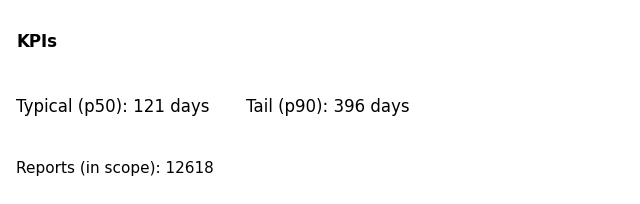

📸 Saved: /content/charts/01_kpis_p50_p90_reports.png


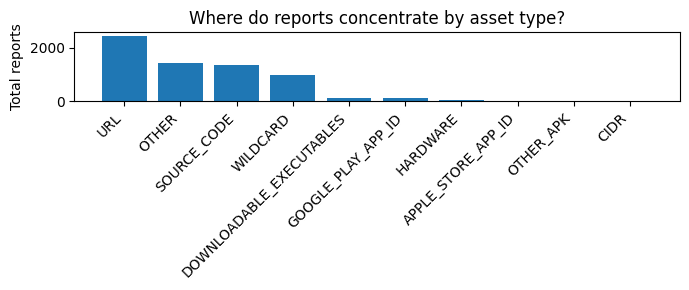

📸 Saved: /content/charts/02_asset_concentration_bar.png


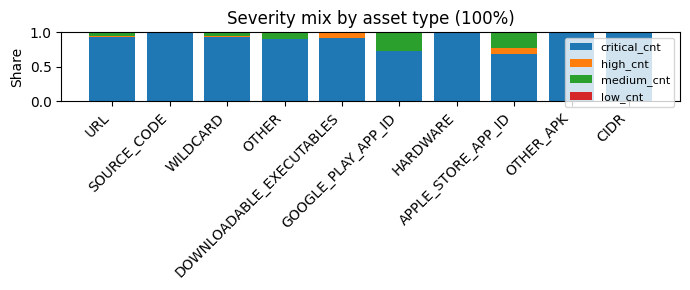

📸 Saved: /content/charts/03_severity_mix_100pct.png


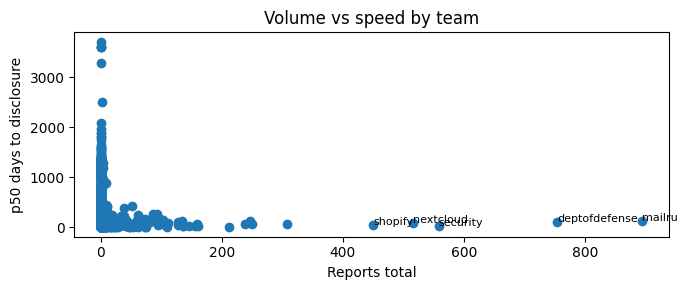

📸 Saved: /content/charts/04_team_volume_vs_p50_scatter.png


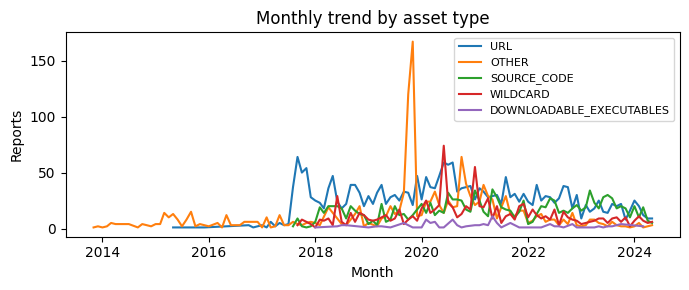

📸 Saved: /content/charts/05_monthly_trend_asset_type.png


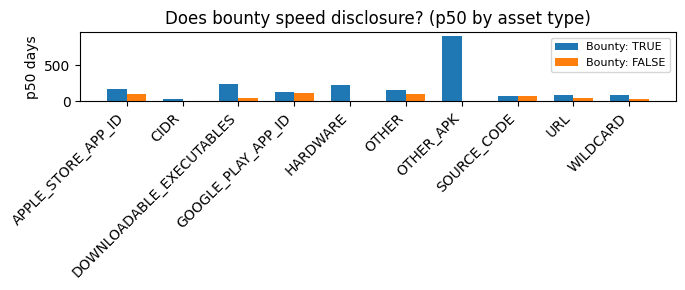

📸 Saved: /content/charts/06_bounty_p50_grouped.png


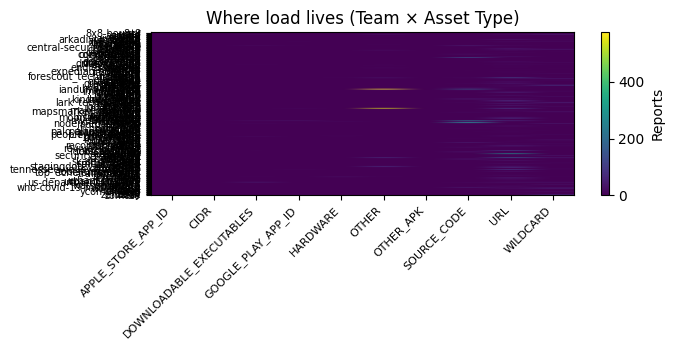

📸 Saved: /content/charts/07_heatmap_team_asset.png


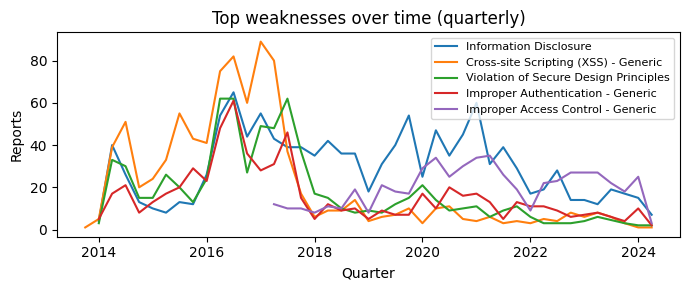

📸 Saved: /content/charts/08_weakness_trend_quarterly.png


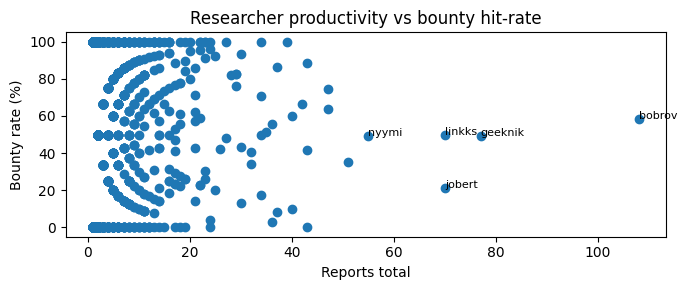

📸 Saved: /content/charts/09_reporter_quality_scatter.png


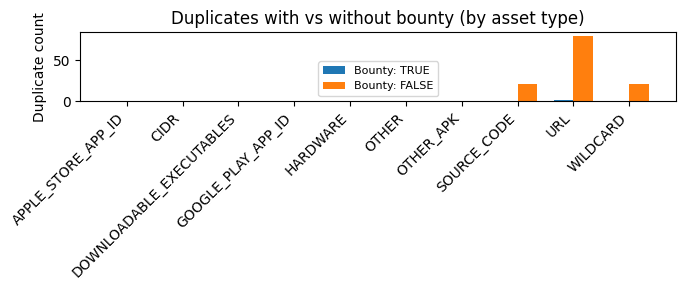

📸 Saved: /content/charts/10_bounty_duplicates_grouped.png


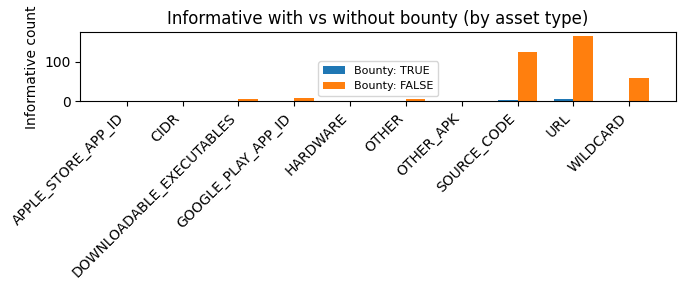

📸 Saved: /content/charts/11_bounty_informative_grouped.png

✅ Done. Charts saved to: /content/charts
• Open the HTML dashboard in the left Files pane: /content/charts/dashboard.html
• PNGs live alongside it for slides.


In [ ]:
# -------------------- 1) KPI Banner --------------------
title = "KPIs — Typical (p50), Tail (p90), Reports"

df_kpi = qdf("""
SELECT
  SUM(p50_days_to_disclosure * reports_total) / NULLIF(SUM(reports_total),0) AS kpi_p50_days,
  SUM(p90_days_to_disclosure * reports_total) / NULLIF(SUM(reports_total),0) AS kpi_p90_days,
  SUM(reports_total) AS reports_total
FROM mart_team_sla_and_outcomes;
""")

fig = plt.figure(figsize=(8, 2.4))
plt.axis('off')
plt.text(0.01, 0.8, "KPIs", fontsize=12, fontweight='bold')
if not df_kpi.empty and pd.notna(df_kpi.loc[0, "kpi_p50_days"]):
    plt.text(0.01, 0.45, f"Typical (p50): {int(round(df_kpi.loc[0,'kpi_p50_days']))} days", fontsize=12)
    plt.text(0.38, 0.45, f"Tail (p90): {int(round(df_kpi.loc[0,'kpi_p90_days']))} days", fontsize=12)
    plt.text(0.01, 0.12, f"Reports (in scope): {int(df_kpi.loc[0,'reports_total'])}", fontsize=11)
else:
    plt.text(0.01, 0.45, "Typical (p50): n/a", fontsize=12)
    plt.text(0.38, 0.45, "Tail (p90): n/a", fontsize=12)
    plt.text(0.01, 0.12, "Reports (in scope): n/a", fontsize=11)
saved_paths.append(save_fig(fig, "01_kpis_p50_p90_reports"))


# -------------------- 2) Asset concentration (bar) --------------------
title = "Where do reports concentrate by asset type?"

df_asset = qdf("""
SELECT asset_type, total_reports
FROM mart_asset_risk_by_type
ORDER BY total_reports DESC;
""")
if not df_asset.empty:
    d = clean_cat_num(df_asset, "asset_type", "total_reports")
    fig = plt.figure(figsize=(7,3))
    plt.bar(d["asset_type"], d["total_reports"])
    plt.title(title)
    plt.ylabel("Total reports")
    plt.xticks(ticks=np.arange(len(d)), labels=safe_xticks(d["asset_type"]), rotation=45, ha='right')
    plt.tight_layout()
    saved_paths.append(save_fig(fig, "02_asset_concentration_bar"))
else:
    print("Skipped asset concentration: mart_asset_risk_by_type not available or empty.")

# -------------------- 3) Severity mix (100% stacked) --------------------
title = "Severity mix by asset type (100%)"

df_sev = qdf("""
SELECT asset_type, critical_cnt, high_cnt, medium_cnt, low_cnt
FROM mart_asset_risk_by_type;
""")
if not df_sev.empty:
    d = df_sev.dropna(subset=["asset_type"]).copy()
    d["asset_type"] = d["asset_type"].astype(str)
    sev_cols = ["critical_cnt","high_cnt","medium_cnt","low_cnt"]
    d["__total"] = d[sev_cols].sum(axis=1).replace(0, np.nan)
    for c in sev_cols: d[c] = d[c] / d["__total"]
    fig = plt.figure(figsize=(7,3))
    bottom = np.zeros(len(d))
    for c in sev_cols:
        plt.bar(d["asset_type"], d[c], bottom=bottom, label=c)
        bottom += d[c].fillna(0).values
    plt.title(title)
    plt.ylabel("Share")
    plt.ylim(0,1)
    plt.xticks(ticks=np.arange(len(d)), labels=safe_xticks(d["asset_type"]), rotation=45, ha='right')
    plt.legend(fontsize=8)
    plt.tight_layout()
    saved_paths.append(save_fig(fig, "03_severity_mix_100pct"))

else:
    print("Skipped severity mix: mart_asset_risk_by_type not available or empty.")

# -------------------- 4) Volume vs speed by team (scatter) --------------------
title = "Volume vs speed by team"

df_team = qdf("""
SELECT team_handle, reports_total, p50_days_to_disclosure
FROM mart_team_sla_and_outcomes
WHERE team_handle IS NOT NULL;
""")
if not df_team.empty and {"reports_total","p50_days_to_disclosure"}.issubset(df_team.columns):
    fig = plt.figure(figsize=(7,3))
    plt.scatter(df_team["reports_total"], df_team["p50_days_to_disclosure"])
    plt.title(title)
    plt.xlabel("Reports total")
    plt.ylabel("p50 days to disclosure")
    top = df_team.sort_values("reports_total", ascending=False).head(5)
    for _, r in top.iterrows():
        try:
            plt.annotate(str(r["team_handle"]), (r["reports_total"], r["p50_days_to_disclosure"]), fontsize=8)
        except Exception:
            pass
    plt.tight_layout()
    saved_paths.append(save_fig(fig, "04_team_volume_vs_p50_scatter"))
else:
    print("Skipped team scatter: missing columns or table empty.")

# -------------------- 5) Monthly trend by asset type (lines) --------------------
title = "Monthly trend by asset type"


df_month = qdf("""
SELECT month, asset_type, reports
FROM vw_calendarized_asset_type_trend;
""")
if not df_month.empty:
    d = df_month.dropna(subset=["asset_type","reports"]).copy()
    # best-effort month parse
    try:
        d["month"] = pd.to_datetime(d["month"])
    except Exception:
        d["month"] = pd.to_datetime(d["month"], errors="coerce")
    d = d.dropna(subset=["month"])
    # top 5 types in window
    top_types = d.groupby("asset_type")["reports"].sum().sort_values(ascending=False).head(5).index.tolist()
    fig = plt.figure(figsize=(7,3))
    for at in top_types:
        sub = d[d["asset_type"] == at].sort_values("month")
        plt.plot(sub["month"], sub["reports"], label=str(at))
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel("Reports")
    if top_types: plt.legend(fontsize=8)
    plt.tight_layout()
    saved_paths.append(save_fig(fig, "05_monthly_trend_asset_type"))

else:
    print("Skipped monthly trend: vw_calendarized_asset_type_trend not available or empty.")

# -------------------- 6) Bounty speed delta (grouped bar) --------------------
title = "Does bounty speed disclosure? (p50 by asset type)"


df_bounty = qdf("""
SELECT asset_type, has_bounty, p50_days_to_disclosure
FROM mart_bounty_impact;
""")
if not df_bounty.empty:
    piv = df_bounty.pivot_table(index="asset_type", columns="has_bounty",
                                values="p50_days_to_disclosure", aggfunc="mean").dropna(how="all")
    if not piv.empty:
        piv.index = piv.index.astype(str)
        x = np.arange(len(piv)); w = 0.35
        fig = plt.figure(figsize=(7,3))
        if True in piv.columns:
            plt.bar(x - w/2, piv[True].values, w, label="Bounty: TRUE")
        if False in piv.columns:
            plt.bar(x + w/2, piv[False].values, w, label="Bounty: FALSE")
        plt.title(title)
        plt.ylabel("p50 days")
        plt.xticks(x, safe_xticks(list(piv.index)), rotation=45, ha='right')
        plt.legend(fontsize=8)
        plt.tight_layout()
        saved_paths.append(save_fig(fig, "06_bounty_p50_grouped"))

    else:
        print("Skipped bounty grouped: pivot empty.")
else:
    print("Skipped bounty grouped: mart_bounty_impact not available or empty.")

# -------------------- 7) Team × Asset heatmap --------------------
title = "Where load lives (Team × Asset Type)"


df_snap = qdf("""
SELECT team_handle, asset_type, reports
FROM vw_program_health_snapshot;
""")
if not df_snap.empty:
    mat = df_snap.pivot_table(index="team_handle", columns="asset_type",
                              values="reports", aggfunc="sum").fillna(0)
    if not mat.empty:
        mat.index = mat.index.astype(str)
        mat.columns = mat.columns.astype(str)
        fig = plt.figure(figsize=(7,3.6))
        plt.imshow(mat.values, aspect='auto')
        plt.colorbar(label="Reports")
        plt.title(title)
        plt.yticks(ticks=np.arange(len(mat.index)), labels=mat.index, fontsize=7)
        plt.xticks(ticks=np.arange(len(mat.columns)), labels=safe_xticks(list(mat.columns)), rotation=45, ha='right', fontsize=8)
        plt.tight_layout()
        saved_paths.append(save_fig(fig, "07_heatmap_team_asset"))

    else:
        print("Skipped heatmap: pivot produced no data.")
else:
    print("Skipped heatmap: vw_program_health_snapshot not available or empty.")

# -------------------- 8) Weakness trend (quarterly lines) --------------------
title = "Top weaknesses over time (quarterly)"

df_w = qdf("""
SELECT quarter, weakness_name, reports
FROM mart_weakness_trend_qtr;
""")
if not df_w.empty:
    d = df_w.dropna(subset=["weakness_name","reports"]).copy()
    # try to parse quarter; if fails, we'll just plot as categories
    try:
        d["__quarter_dt"] = pd.to_datetime(d["quarter"])
        xfield = "__quarter_dt"
    except Exception:
        xfield = "quarter"
    top5 = d.groupby("weakness_name")["reports"].sum().sort_values(ascending=False).head(5).index.tolist()
    fig = plt.figure(figsize=(7,3))
    for w in top5:
        sub = d[d["weakness_name"] == w].sort_values(xfield)
        plt.plot(sub[xfield], sub["reports"], label=str(w))
    plt.title(title)
    plt.xlabel("Quarter")
    plt.ylabel("Reports")
    if top5: plt.legend(fontsize=8)
    plt.tight_layout()
    saved_paths.append(save_fig(fig, "08_weakness_trend_quarterly"))
else:
    print("Skipped weakness quarterly trend: mart_weakness_trend_qtr not available or empty.")

# -------------------- 9) Researcher productivity vs bounty hit-rate --------------------
title = "Researcher productivity vs bounty hit-rate"

df_rq = qdf("""
SELECT username, verified, reports_total, bounty_rate_pct
FROM mart_reporter_quality
WHERE username IS NOT NULL;
""")
if not df_rq.empty and {"reports_total","bounty_rate_pct"}.issubset(df_rq.columns):
    fig = plt.figure(figsize=(7,3))
    plt.scatter(df_rq["reports_total"], df_rq["bounty_rate_pct"])
    plt.title(title)
    plt.xlabel("Reports total")
    plt.ylabel("Bounty rate (%)")
    top = df_rq.sort_values("reports_total", ascending=False).head(5)
    for _, r in top.iterrows():
        try:
            plt.annotate(str(r["username"]), (r["reports_total"], r["bounty_rate_pct"]), fontsize=8)
        except Exception:
            pass
    plt.tight_layout()
    saved_paths.append(save_fig(fig, "09_reporter_quality_scatter"))
else:
    print("Skipped reporter quality scatter: mart_reporter_quality missing columns or empty.")

# -------------------- 10) Duplicates with vs without bounty --------------------
title = "Duplicates with vs without bounty (by asset type)"

df_dup = qdf("""
SELECT asset_type, has_bounty, duplicate_cnt
FROM mart_bounty_impact;
""")
if not df_dup.empty and not df_dup["asset_type"].isna().all():
    piv = df_dup.pivot_table(index="asset_type", columns="has_bounty",
                             values="duplicate_cnt", aggfunc="sum").dropna(how="all")
    if not piv.empty:
        piv.index = piv.index.astype(str)
        x = np.arange(len(piv)); w = 0.35
        fig = plt.figure(figsize=(7,3))
        if True in piv.columns:
            plt.bar(x - w/2, piv[True].values, w, label="Bounty: TRUE")
        if False in piv.columns:
            plt.bar(x + w/2, piv[False].values, w, label="Bounty: FALSE")
        plt.title(title)
        plt.ylabel("Duplicate count")
        plt.xticks(x, safe_xticks(list(piv.index)), rotation=45, ha='right')
        plt.legend(fontsize=8)
        plt.tight_layout()
        saved_paths.append(save_fig(fig, "10_bounty_duplicates_grouped"))

    else:
        print("Skipped duplicates grouped: pivot empty.")
else:
    print("Skipped duplicates grouped: mart_bounty_impact not available or empty.")

# -------------------- 11) Informative with vs without bounty --------------------
title = "Informative with vs without bounty (by asset type)"

df_info = qdf("""
SELECT asset_type, has_bounty, informative_cnt
FROM mart_bounty_impact;
""")
if not df_info.empty and not df_info["asset_type"].isna().all():
    piv = df_info.pivot_table(index="asset_type", columns="has_bounty",
                              values="informative_cnt", aggfunc="sum").dropna(how="all")
    if not piv.empty:
        piv.index = piv.index.astype(str)
        x = np.arange(len(piv)); w = 0.35
        fig = plt.figure(figsize=(7,3))
        if True in piv.columns:
            plt.bar(x - w/2, piv[True].values, w, label="Bounty: TRUE")
        if False in piv.columns:
            plt.bar(x + w/2, piv[False].values, w, label="Bounty: FALSE")
        plt.title(title)
        plt.ylabel("Informative count")
        plt.xticks(x, safe_xticks(list(piv.index)), rotation=45, ha='right')
        plt.legend(fontsize=8)
        plt.tight_layout()
        saved_paths.append(save_fig(fig, "11_bounty_informative_grouped"))

    else:
        print("Skipped informative grouped: pivot empty.")
else:
    print("Skipped informative grouped: mart_bounty_impact not available or empty.")

# -------------------- 12) Simple HTML dashboard with all charts --------------------
html_path = OUT_DIR / "dashboard.html"
with open(html_path, "w", encoding="utf-8") as f:
    f.write("<html><head><meta charset='utf-8'><title>Challenge 1 — Colab Dashboard</title></head><body>")
    f.write("<h2>Challenge 1 — Dashboard (Charts from DuckDB)</h2>")
    f.write("<p>Each image below is a separate figure generated in this session.</p>")
    for p in saved_paths:
        f.write(f"<div style='margin:16px 0;'><img src='{Path(p).name}' style='max-width:100%; border:1px solid #ddd; padding:4px;'></div>")
    f.write("</body></html>")

print("\n✅ Done. Charts saved to:", OUT_DIR)
print("• Open the HTML dashboard in the left Files pane:", html_path)
print("• PNGs live alongside it for slides.")